In [335]:
import os
import time
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [336]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [337]:
root_path = '/kaggle/input/early-detection-of-3d-printing-issues/'
df_train = pd.read_csv(root_path + 'train.csv', dtype=object)
df_test = pd.read_csv(root_path + 'test.csv', dtype=object)
print(df_train.shape)
print(df_test.shape)

(81060, 4)
(25279, 3)


In [338]:
# size_set = set()
# for ind, row in df_train.iterrows():
#     size = Image.open(os.path.join(root_path, "images", df_train.iloc[ind]['img_path'])).size
#     size_set.add(size)
# print(size_set)

In [339]:
# print(size_set)

### All the images are not of equal shape, so we will have to resize the images

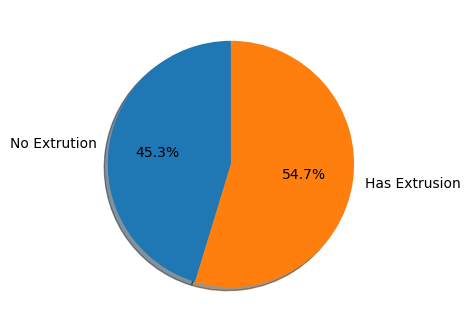

In [340]:
label = ['No Extrution', 'Has Extrusion']
plt.figure(figsize = (4,4))
plt.pie(df_train.groupby('has_under_extrusion').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

### Hence we have evenly balanced image Dataset, is what we can see from the pie chart

Now, Let's see how data is collected per printer

<AxesSubplot:title={'center':'test'}, xlabel='printer_id'>

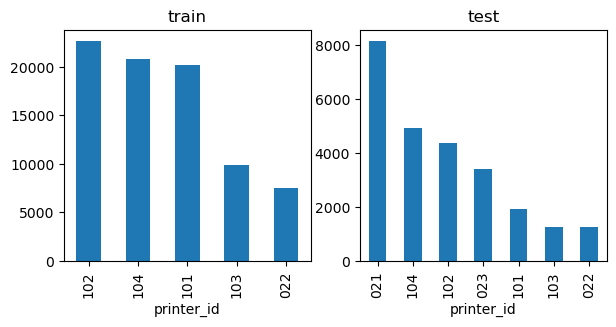

In [341]:
plt.figure(figsize = (7,3))
plt.subplot(1, 2, 1)
plt.title('train')
plt.xlabel('printer_id')
df_train['printer_id'].value_counts().plot(kind='bar')
plt.subplot(1,2,2)
plt.title('test')
plt.xlabel('printer_id')
df_test['printer_id'].value_counts().plot(kind='bar')

### As it's provided in data description that printer 021 and 023 are reserved for testing the model
<br />

In [342]:
# custom Dataset class to convert the dataset which is compatible with torch dataloader
class PrinterImageDataset(Dataset):
    classes = [0,1]
    def __init__(self, root, csv_file, transform=None):
            self.root = root
            csv_file = pd.read_csv(csv_file)
            self.image_files = [os.path.join(root, "images", img_path) for img_path in csv_file.iloc[:,0]]
            self.data = csv_file.iloc[:, 3]
            self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_name = self.image_files[index]  
        image = PIL.Image.open(image_name)
        label = self.data[index]
        if self.transform:
            image = self.transform(image)
        return (image.type(torch.FloatTensor), label)

In [343]:
BATCH_SIZE = 64
mean = [0.4766, 0.4527, 0.3926]
std = [0.2275, 0.2224, 0.2210]
def get_transforms(training):
    img_transforms = []
    if(training):
        img_transforms.append(transforms.RandomHorizontalFlip(0.5))
        img_transforms.append(transforms.RandomRotation(60))
        img_transforms.append(transforms.Resize((400,400), interpolation=transforms.InterpolationMode.NEAREST))
    
    img_transforms.append(transforms.ToTensor())
    
    if(training):
        img_transforms.append(transforms.Normalize(mean, std))
        
    return transforms.Compose(img_transforms)

train_dataset = PrinterImageDataset(root_path, os.path.join(root_path, 'train.csv'), get_transforms(True))


In [344]:
training_data, validation_data = random_split(train_dataset, [70000, 11060])
training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, num_workers = 2, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers = 2, shuffle=False)


In [345]:
print(models.vgg16().features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [346]:
INPUT_IMG_SIZE = [400, 400]
class CustomVGG(nn.Module):


    def __init__(self, n_classes=2):
        super(CustomVGG, self).__init__()
        self.feature_extractor = models.vgg16(pretrained=True).features[:-8]
        self.classification_head = nn.Sequential(
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=(INPUT_IMG_SIZE[0] // 2 ** 5, INPUT_IMG_SIZE[1] // 2 ** 5)),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(
                in_features=self.feature_extractor[-2].out_channels,
                out_features=self.feature_extractor[-2].out_channels
            ),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(
                in_features=self.feature_extractor[-2].out_channels,
                out_features=n_classes
            )
        )
        self._freeze_params()

    def _freeze_params(self):
        for param in self.feature_extractor[:17].parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.feature_extractor(x)
        scores = self.classification_head(x)
        return scores

In [354]:
def train_model(dataloader, model, optimizer, criterion, epochs, device, target_accuracy=None):
    model.to(device)
    model.train()

    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}:")
        running_loss = 0
        running_corrects = 0
        n_samples = 0
        i = 1
        
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds_scores = model(images)
            preds_class = torch.argmax(preds_scores, dim=-1)
#             preds_prob, _ = torch.max(preds_scores, 1)
            loss = criterion(preds_scores, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds_class == labels)
            n_samples += images.size(0)
            if(i%100 == 0):
                print(f'{i} step of {len(dataloader)}')
                print("Training Loss = {:.4f}, Training Accuracy = {:.4f}".format(running_loss/n_samples, running_corrects.double()/n_samples))
            i = i+1
            
        epoch_loss = running_loss / n_samples
        epoch_acc = running_corrects.double() / n_samples
        print("Training Loss = {:.4f}, Training Accuracy = {:.4f}".format(epoch_loss, epoch_acc))
        
        evaluate_model(model, validation_dataloader, device)
        print('------------------')
        if target_accuracy != None:
            if epoch_acc > target_accuracy:
                print("Early Stopping")
                break

    return model


def evaluate_model(model, dataloader, device):
    model.to(device)
    model.eval()

    running_corrects = 0
    y_true = np.empty(shape=(0,))
    y_pred = np.empty(shape=(0,))
    i = 0
    print('Validation step')
    validation_start = time.time()
    for images, labels in dataloader:
        
        images = images.to(device)
        labels = labels.to(device)

        preds_probs = model(images)
        preds_class = torch.argmax(preds_probs, dim=-1)

        labels = labels.to("cpu").numpy()
        preds_class = preds_class.detach().to("cpu").numpy()

        y_true = np.concatenate((y_true, labels))
        y_pred = np.concatenate((y_pred, preds_class))
    
    validation_end = time.time()
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')

    print("Accuracy: {:.4f}".format(accuracy))
    print("F1 SCORE: {:.4f}".format(f1))
    print('Time to validate', validation_end - validation_start)    
    

In [355]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomVGG()
model= nn.DataParallel(model,device_ids = [i for i in range(torch.cuda.device_count())])
model.load_state_dict(torch.load('/kaggle/working/checkpoint1680120962.0157568.pth'))
model.to(device)
criterion = nn.CrossEntropyLoss() # CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = train_model(training_dataloader, model, optimizer, criterion, 20, device, 0.99)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20:
100 step of 1094
Training Loss = 0.0401, Training Accuracy = 0.9881
200 step of 1094
Training Loss = 0.0381, Training Accuracy = 0.9874
300 step of 1094
Training Loss = 0.0356, Training Accuracy = 0.9878
400 step of 1094
Training Loss = 0.0403, Training Accuracy = 0.9863
500 step of 1094
Training Loss = 0.0395, Training Accuracy = 0.9869
600 step of 1094
Training Loss = 0.0375, Training Accuracy = 0.9876
700 step of 1094
Training Loss = 0.0352, Training Accuracy = 0.9884
800 step of 1094
Training Loss = 0.0341, Training Accuracy = 0.9887
900 step of 1094
Training Loss = 0.0336, Training Accuracy = 0.9890
1000 step of 1094
Training Loss = 0.0323, Training Accuracy = 0.9894
Training Loss = 0.0314, Training Accuracy = 0.9897
Validation step


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/tmp/ipykernel_23/2373545602.py", line 30, in forward
    x = self.feature_extractor(x)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py", line 204, in forward
    input = module(input)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py", line 1190, in _call_impl
    return forward_call(*input, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py", line 463, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.7/site-packages/torch/nn/modules/conv.py", line 460, in _conv_forward
    self.padding, self.dilation, self.groups)
RuntimeError: Unable to find a valid cuDNN algorithm to run convolution


In [356]:
latest_checkpoint = 'checkpoint' + str(time.time()) +'.pth'
torch.save(model.state_dict(), latest_checkpoint)

In [362]:
model.load_state_dict(torch.load('/kaggle/working/' + latest_checkpoint))
model.to(device)
model.eval()
class PrinterImageDatasetTest(Dataset):
    classes = [0,1]
    def __init__(self, root, csv_file, transform=None):
            self.root = root
            csv_file = pd.read_csv(csv_file)
            self.image_path = [img_path for img_path in csv_file.iloc[:,0]]
            self.image_files = [os.path.join(root, "images", img_path) for img_path in csv_file.iloc[:,0]]
            self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_name = self.image_files[index]
        image_path = self.image_path[index]
        image = PIL.Image.open(image_name)
        if self.transform:
            image = self.transform(image)
        return (image, image_path)
    
test_dataset = PrinterImageDatasetTest(root_path, os.path.join(root_path, 'test.csv'), get_transforms(False))
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers = 2, shuffle=False)

res = []
for img, img_path in test_dataloader:
    img = img.to(device)
    preds_probs = model(img)
    preds_class = torch.argmax(preds_probs, dim=-1)
    preds_class = preds_class.cpu().detach().numpy()
    for i in range(len(img_path)):
        res.append([img_path[i], int(preds_class[i])])
df = pd.DataFrame(res, columns = ['img_path', 'has_under_extrusion'])
df.to_csv('submission'+ str(time.time()) +'.csv', index=None)